<a href="https://colab.research.google.com/github/yashnaik270/Coronary-Artery-Disease/blob/main/CAD_blockage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/CAD_augmented.csv")

import numpy as np

data['Blockage (%)'] = (
    data['BP '] * 0.08 +
    (100 - data['EF-TTE']) * 0.1 +
    data['St Depression'] * 5 +
    data['St Elevation'] * 5 +
    data['Q Wave'] * 3 +
    data['Tinversion'] * 3 +
    data['Region RWMA'] * 5 +
    data['CR'] * 0.1 +
    data['TG'] * 0.05 +
    (50 - data['HDL']) * 0.08 +
    data['HTN'] * 5 +
    data['DM'] * 5 +
    data['age'] * 0.05
)

# Normalize between 0-100
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))
data['Blockage (%)'] = scaler.fit_transform(data[['Blockage (%)']])

# Correction based on Cath label
data.loc[data['Cath'] == 0, 'Blockage (%)'] = data.loc[data['Cath'] == 0, 'Blockage (%)'].apply(lambda x: np.clip(x, 10, 49))
data.loc[data['Cath'] == 1, 'Blockage (%)'] = data.loc[data['Cath'] == 1, 'Blockage (%)'].apply(lambda x: np.clip(x, 50, 95))


# # Save the updated dataset
# data.to_csv("CAD_augmented_with_blockage.csv", index=False)

# from google.colab import files
# files.download('CAD_augmented_with_blockage.csv')


In [2]:
def label_severity(b):
    if b < 30: return 'Mild'
    elif b < 70: return 'Moderate'
    else: return 'Severe'

data['CAD Severity'] = data['Blockage (%)'].apply(label_severity)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Step 1: Load dataset
data = pd.read_csv("/content/drive/MyDrive/CAD_augmented_with_blockage.csv")  # Use your downloaded file path

# Step 2: Split features (X) and target (y)
X = data.drop(columns=['Blockage (%)','Cath'])  # Features only
y = data['Blockage (%)']  # Target

# Step 3: Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train model
model = XGBRegressor()
model.fit(X_train, y_train)

# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(" XGBoost Regressor Results")
print(f" Mean Absolute Error: {mae:.2f}")
print(f" R² Score: {r2:.4f}")

# Predict on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Define accuracy as predictions within ±5% of actual value
def regression_accuracy(y_true, y_pred, tolerance=5):
    within_tolerance = abs(y_true - y_pred) <= tolerance
    return within_tolerance.sum() / len(y_true)

train_acc = regression_accuracy(y_train, y_train_pred)
test_acc = regression_accuracy(y_test, y_test_pred)

print(f" Training Accuracy (±5% tolerance): {train_acc * 100:.2f}%")
print(f" Testing Accuracy  (±5% tolerance): {test_acc * 100:.2f}%")



 XGBoost Regressor Results
 Mean Absolute Error: 1.33
 R² Score: 0.9718
 Training Accuracy (±5% tolerance): 96.78%
 Testing Accuracy  (±5% tolerance): 94.60%


In [4]:
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [5]:
def regression_accuracy(y_true, y_pred, tolerance=5):
    within_tolerance = abs(y_true - y_pred) <= tolerance
    return within_tolerance.sum() / len(y_true)


In [6]:
# Train CatBoost Regressor
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)

# Predict
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)

# Evaluation
mae_cat = mean_absolute_error(y_test, y_test_pred_cat)
r2_cat = r2_score(y_test, y_test_pred_cat)
train_acc_cat = regression_accuracy(y_train, y_train_pred_cat)
test_acc_cat = regression_accuracy(y_test, y_test_pred_cat)

print(" CatBoost Regressor Results")
print(f" MAE: {mae_cat:.2f}")
print(f" R²: {r2_cat:.4f}")
print(f" Training Accuracy (±5%): {train_acc_cat * 100:.2f}%")
print(f" Testing Accuracy  (±5%): {test_acc_cat * 100:.2f}%\n")


 CatBoost Regressor Results
 MAE: 2.04
 R²: 0.9607
 Training Accuracy (±5%): 92.85%
 Testing Accuracy  (±5%): 89.30%



In [7]:
# Predict for one new patient (example: row 11)
X = X.reset_index(drop=True)
new_patient = X.iloc[181].values.reshape(1, -1)

predicted_blockage = model.predict(new_patient)[0]

def label_severity(blockage):
    if blockage < 30: return 'Mild Blockage'
    elif blockage < 70: return 'Moderate Blockage is Found'
    else: return 'Severe CAD'

predicted_severity = label_severity(predicted_blockage)

print(" Patient Risk Report")
print(f" Predicted Blockage: {predicted_blockage:.2f}%")
print(f" Severity Level: {predicted_severity}")

# Recommendation logic (fixed strings)
if predicted_severity == 'Severe CAD':
    print(" High Risk: Immediate medical evaluation recommended.")
elif predicted_severity == 'Moderate Blockage is Found':
    print(" Moderate Risk: Further diagnostic tests advised.")
else:  # Mild
    print(" Low Risk: No immediate intervention needed.")



 Patient Risk Report
 Predicted Blockage: 49.61%
 Severity Level: Moderate Blockage is Found
 Moderate Risk: Further diagnostic tests advised.


In [10]:
X = X.reset_index(drop=True)
new_patient = X.iloc[551].values.reshape(1, -1)

predicted_blockage = model.predict(new_patient)[0]

def label_severity(blockage):
    if blockage < 30: return 'Mild Blockage'
    elif blockage < 70: return 'Moderate Blockage is Found'
    else: return 'Severe CAD'

predicted_severity = label_severity(predicted_blockage)

print(" Patient Risk Report")
print(f" Predicted Blockage: {predicted_blockage:.2f}%")
print(f" Severity Level: {predicted_severity}")

# Recommendation logic (fixed strings)
if predicted_severity == 'Severe CAD':
    print(" High Risk: Immediate medical evaluation recommended.")
elif predicted_severity == 'Moderate Blockage is Found':
    print(" Moderate Risk: Further diagnostic tests advised.")
else:  # Mild
    print(" Low Risk: No immediate intervention needed.")


 Patient Risk Report
 Predicted Blockage: 13.97%
 Severity Level: Mild Blockage
 Low Risk: No immediate intervention needed.


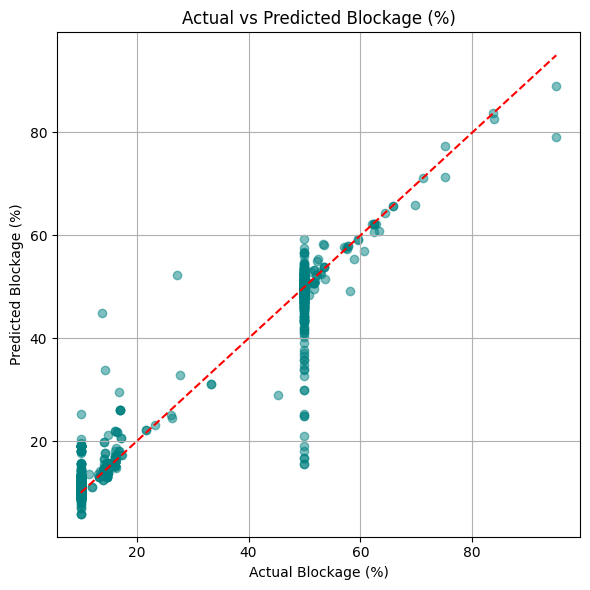

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([10, 95], [10, 95], '--r')  # Ideal prediction line
plt.xlabel("Actual Blockage (%)")
plt.ylabel("Predicted Blockage (%)")
plt.title("Actual vs Predicted Blockage (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# import joblib
# joblib.dump(model, "cad_blockage_model.pkl")
# from google.colab import files
# files.download('cad_blockage_model.pkl')
